## Loading the required libraries

In [61]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
from torch.autograd.variable import Variable
from torch import optim
import torch.nn.functional as F

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Loading the MNIST dataset

### Downloading train and test datasets

In [62]:
#Loading training data
train = datasets.MNIST(
    root="", #Folder where the dataset to be stored; empty means stored in current folder
    train=True, #Download the 'training' dataset, False => download 'test' dataset
    download=True, #Should be 'True' in the first time downling the dataset, else 'False'
    transform=transforms.Compose([transforms.ToTensor()])
)

#Loading test data
test = datasets.MNIST(
    root="",
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)

### Wraping downloaded datasets into data loaders

In [63]:
from torch.utils.data import DataLoader

trainDL = DataLoader(train, batch_size=8, shuffle=True)
testDL  = DataLoader(test, batch_size=8, shuffle=True)
print("Batch size = ", trainDL.batch_size)
print("Batch size = ", testDL.batch_size)

Batch size =  8
Batch size =  8


### Getting the first batch of images and their labels

In [64]:
data_itr = iter(trainDL)
first_batch_of_images, first_batch_of_labels = data_itr.next()
print(first_batch_of_images.shape)

torch.Size([8, 1, 28, 28])


## Discriminator class

In [65]:
class DiscriminatorNet(torch.nn.Module):
    '''
    Three hidden layered discriminative neural network
    Input - 1D tensor of size 784 (Equivalent to image of size 28*28)
    Output - Probability(Image is a fake)
    '''
    def __init__(self, input_dim):
        super(DiscriminatorNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        x = torch.sigmoid(self.fc4(x))
        return x
        
D = DiscriminatorNet(784).to(device)
print(D)

DiscriminatorNet(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=1, bias=True)
)


## Conversion functions

### Images to vectors

In [66]:
def images2vectors(images):
    '''
    Converts batch of image tensors to batch of 1D tensors
    '''
    return images.view(images.shape[0], 784)

In [67]:
converted_vectors = images2vectors(first_batch_of_images)
print(converted_vectors.shape)

torch.Size([8, 784])


### Vectors to images

In [68]:
def vectors2images(vectors):
    '''
    Converts a batch 1D tensors to batch of 2D images 
    '''
    return vectors.view(vectors.shape[0], 1, 28, 28)

In [69]:
converted_images = vectors2images(converted_vectors)
print(converted_images.shape)

torch.Size([8, 1, 28, 28])


## Generator class

In [70]:
class GeneratorNet(torch.nn.Module):
    '''
    Three hidden layered generative neural network
    Input - Vector of size 100 (random)
    Output - Vector of size 784 (image of 28*28)
    '''
    def __init__(self, input_dim, output_dim):
        super(GeneratorNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, output_dim)
        
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = torch.tanh(self.fc4(x))
        return x
    
G = GeneratorNet(input_dim=100, output_dim=784).to(device)
print(G)

GeneratorNet(
  (fc1): Linear(in_features=100, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=784, bias=True)
)


## Other required functions

### Noise function

In [71]:
def noise(size):
    '''
    Generates a 1D tensor of Gausian random sampled values from N(0,1)
    '''
    n = Variable(torch.randn(size, 100)) #100 - no of inputs to the generator
    return n

### ones_target() function

In [72]:
def ones_target(size):
    '''
    Outputs a tensor containing all ones, with shape = (size, 1)
    '''
    data = Variable(torch.ones(size, 1))
    return data

In [73]:
ones_labels = ones_target(8)
print(ones_labels.shape)
print(ones_labels)

torch.Size([8, 1])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])


### zeros_target() function

In [74]:
def zeros_target(size):
    '''
    Outputs a tensor containing all zeros, with shape = (size, 1)
    '''
    data = Variable(torch.zeros(size, 1))
    return data

In [75]:
zero_labels = zeros_target(8)
print(zero_labels.shape)
print(zero_labels)

torch.Size([8, 1])
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])


## Optimizers

In [76]:
D_optimizer = optim.Adam(D.parameters(), lr=0.0002)
G_optimizer = optim.Adam(G.parameters(), lr=0.0002)

## Loss

### Loss function

The binary cross entropy loss

> $ L(y,\hat{y})  = -\frac{1}{N} \sum_{i=0}^{N}[y_i\log (\hat{y_i}) + (1-y_i)\log (1 - \hat{y_i})] $

is used as discriminator does a binary classification.

In [77]:
loss_fn = nn.BCELoss()

### Discriminator loss

The loss is defined as

> $ Loss\_D = \frac{1}{N}\sum_{i=1}^{N}\log D(x^i) + \log(1-D(G(z^i))) $

where $x$ represents a real image and $z$ fake noise. $G(z)$ generates a fake image.

In [78]:
def train_discriminator(x):
    '''
    Train the discriminator 'D' for images 'x' and return its loss
    '''
    D.zero_grad()
    
    # Train the discriminator on real data
    x_real = images2vectors(x).to(device)
    y_real = ones_target(x.shape[0]).to(device)
    pred_real = D(x_real)
    loss_real = loss_fn(pred_real, y_real)
    
    # Train the discriminator on fake data
    x_fake = G(noise(x.shape[0]).to(device))
    y_fake = zeros_target(x.shape[0]).to(device)
    pred_fake = D(x_fake)
    loss_fake = loss_fn(pred_fake, y_fake)
    
    # Gradient backprop and optimize ONLY discriminator(D)'s parameters
    D_loss = loss_real + loss_fake
    D_loss.backward()
    D_optimizer.step()
    
    return D_loss

### Generator loss

The loss is defined as

> $ Loss_G = \frac{1}{m}\sum_{i=1}^{N} \log (1 - D(G(z^{(i)}))) $

In [79]:
def train_generator(x):
    '''
    Train the generator 'G' and rerturn its loss
    '''
    G.zero_grad()
    
    z = noise(x.shape[0]).to(device)
    y = ones_target(x.shape[0]).to(device)
    pred = D(G(z))
    G_loss = loss_fn(pred, y)
    
    # Gradient backprop and optimize ONLY generator(G)'s parameters
    G_loss.backward()
    G_optimizer.step()
    
    return G_loss

## Training

In [80]:
epochs = 10

for epoch in range(epochs):
    d_losses = []
    g_losses = []
    for data in trainDL:
        images, _ = data
        # Training the discriminator (D)
        d_loss = train_discriminator(images)
        d_losses.append(d_loss.item())
        # Training the generator (G)
        g_loss = train_generator(images)
        g_losses.append(g_loss.item())
    print('Epoch [{:5d}/{:5d}] | mean_d_loss: {:6.4f} | mean_g_loss: {:6.4f}'.format(
                epoch+1, epochs, torch.mean(torch.FloatTensor(d_losses)), 
                torch.mean(torch.FloatTensor(g_losses))))

Epoch [    1/   10] | mean_d_loss: 1.0482 | mean_g_loss: 1.4070
Epoch [    2/   10] | mean_d_loss: 0.8146 | mean_g_loss: 1.7788
Epoch [    3/   10] | mean_d_loss: 0.6980 | mean_g_loss: 2.1370
Epoch [    4/   10] | mean_d_loss: 0.5726 | mean_g_loss: 2.6148
Epoch [    5/   10] | mean_d_loss: 0.5047 | mean_g_loss: 2.9259
Epoch [    6/   10] | mean_d_loss: 0.4724 | mean_g_loss: 3.0903
Epoch [    7/   10] | mean_d_loss: 0.4450 | mean_g_loss: 3.2630
Epoch [    8/   10] | mean_d_loss: 0.4226 | mean_g_loss: 3.4020
Epoch [    9/   10] | mean_d_loss: 0.4066 | mean_g_loss: 3.4666
Epoch [   10/   10] | mean_d_loss: 0.3969 | mean_g_loss: 3.4974


## Testing the generator

In [83]:
from torchvision.utils import save_image
import matplotlib.pyplot as plt

with torch.no_grad():
    noise_test = noise(32).to(device)
    print(noise_test.shape)
    G.eval()
    fake_img_vecs = G(noise_test)
    print(fake_img_vecs.shape)
    fake_imgs = fake_img_vecs.view(fake_img_vecs.shape[0], 1, 28, 28)
    print(fake_imgs.shape)
    save_image(fake_imgs, 'fake2'+'.png')

torch.Size([32, 100])
torch.Size([32, 784])
torch.Size([32, 1, 28, 28])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


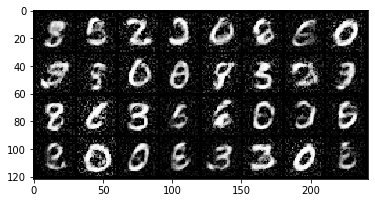

In [84]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision import utils

#Functions to show an image
def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
imshow(utils.make_grid(fake_imgs.detach().to('cpu')))